In [38]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True


In [39]:
file_BKG = up.open("unoscillated_IBD_userfile.root")
dataset = file_BKG ['TRec'].arrays(library = 'np')
en_fact = 0.92
dataset["m_QEn"] = dataset["m_QEn"]*en_fact 

In [40]:
dataset

{'recx': array([-6546.7075, -5635.7627, 13160.146 , ..., -5190.015 , 12472.224 ,
        12667.809 ], dtype=float32),
 'recy': array([12444.845 , 11995.087 ,  5150.4067, ...,  3430.7043, -9249.245 ,
        -9773.4   ], dtype=float32),
 'recz': array([-10109.446 , -10101.866 ,   7890.3755, ..., -14862.485 ,
         -4518.004 ,  -4311.2036], dtype=float32),
 'recQx': array([-6442.929 , -5705.646 , 13194.729 , ..., -5037.3296, 12437.832 ,
        12864.259 ], dtype=float32),
 'recQy': array([12386.451, 12218.745,  5226.838, ...,  3980.325, -9367.034,
        -9797.295], dtype=float32),
 'recQz': array([-10232.933 ,  -9764.068 ,   7777.6704, ..., -14777.744 ,
         -4417.81  ,  -3911.5215], dtype=float32),
 'recTx': array([-6549.019 , -5644.8965, 13170.58  , ..., -5184.5845, 12450.898 ,
        12696.877 ], dtype=float32),
 'recTy': array([12449.238 , 12014.527 ,  5154.4897, ...,  3427.1145, -9233.431 ,
        -9795.826 ], dtype=float32),
 'recTz': array([-10113.016 , -10118.238 ,   

In [41]:
xs_reco = file_BKG['TRec']['recx'].array(library = 'np')
ys_reco = file_BKG['TRec']['recy'].array(library = 'np')
zs_reco = file_BKG['TRec']['recz'].array(library = 'np')
es_reco_BKG = file_BKG['TRec']['m_QEn'].array(library = 'np')

rs_reco = np.sqrt(xs_reco**2 + ys_reco**2 + zs_reco**2)

Text(0, 0.5, 'Number of events')

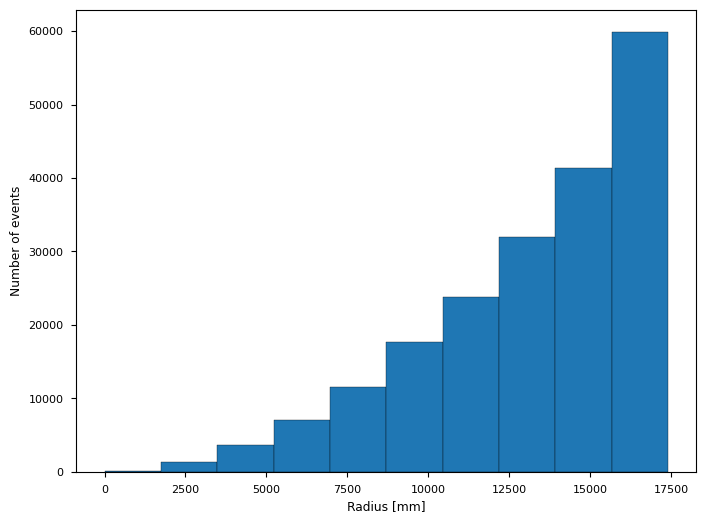

In [42]:
fig, ax = plt.subplots(figsize = (8,6), )
ax.hist(rs_reco)

ax.set_xlabel('Radius [mm]')
ax.set_ylabel('Number of events')

# Cuts

In [43]:
delta_time = 1e6  # ~200us 
delta_radius = 1500 #1.5 m
min_energy_prompt = 0.7 #MeV
max_energy_prompt = 12

min_energy_delay = 1.9 #MeV
max_energy_delay = 2.5

#Here I made some changes
min_energy_delay_carb = 4.4 #MeV
max_energy_delay_carb = 5.5

In [44]:
from numba import njit, prange #prange serve per fare un ciclo for ma eseguito come in c++, molto più veloce


@njit(parallel = True) #il parallel serve per far lavorararre tutti i core in parallelo
def selection(x,y,z,E,t,delta_time = 1e6, delta_radius = 1500, min_energy_prompt = 0.7,max_energy_prompt = 12, min_energy_delay = 1.9, max_energy_delay = 2.5, min_energy_delay_carb = 4.4, max_energy_delay_carb = 5.5):
    prompt_columns = np.zeros(x.shape)
    delay_columns = np.zeros(x.shape)
    delay_columns_carb = np.zeros(x.shape)

    for i_pro in prange(x.shape[0]-1):
        i_del = i_pro + 1


        if t[i_del] - t[i_pro] < delta_time: 
            if np.sqrt((x[i_del] - x[i_pro])**2 + (y[i_del] - y[i_pro])**2 + (z[i_del] - z[i_pro])**2) < delta_radius: #radius cut
                if E[i_pro]>= min_energy_prompt and E[i_pro]<= max_energy_prompt:
                    if E[i_del]>= min_energy_delay and E[i_del]<= max_energy_delay:
                        prompt_columns[i_pro] = 1
                        delay_columns[i_del] = 1
                    if E[i_del]>= min_energy_delay_carb and E[i_del]<= max_energy_delay_carb:
                        prompt_columns[i_pro] = 1
                        delay_columns_carb[i_del] = 1

    return prompt_columns,delay_columns,delay_columns_carb
    

    


In [45]:
prompt_columns, delay_columns, delay_columns_carb = selection(dataset['recx'],dataset['recy'],dataset['recz'],dataset["m_QEn"]*en_fact, dataset["m_triggerT"])

In [46]:
prompt_columns.sum()


95082.0

Text(0.5, 1.0, 'Delayed Events Carbon')

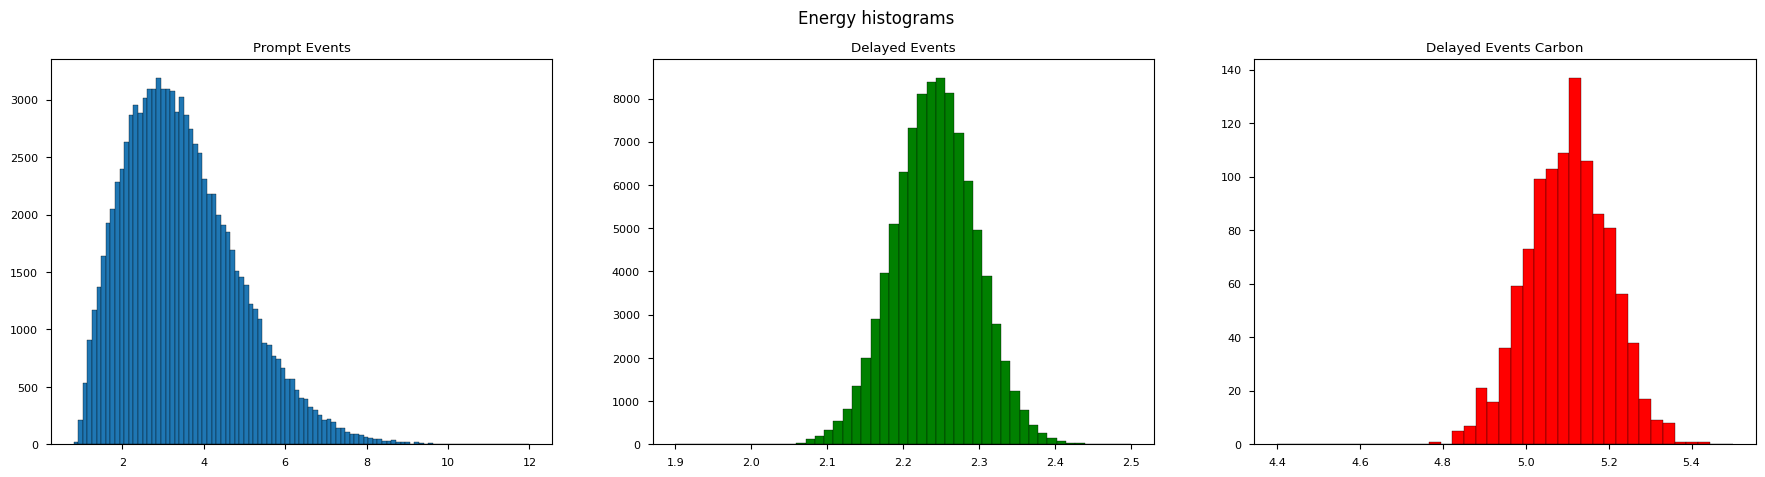

In [47]:
fig_dp, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,5))
fig_dp.suptitle("Energy histograms")

ax1.hist((dataset["m_QEn"])[prompt_columns.astype(bool)], np.linspace(0.8,12,100))
ax1.set_title("Prompt Events")
ax2.hist((dataset["m_QEn"])[delay_columns.astype(bool)], np.linspace(1.9,2.5,50), color = 'green')
ax2.set_title("Delayed Events")
ax3.hist((dataset["m_QEn"])[delay_columns_carb.astype(bool)], np.linspace(4.4,5.5,40), color = 'red')
ax3.set_title("Delayed Events Carbon")